# This notebook uses the outputs of VIDrun.py to plot the VID distributions of L*dndM plot

In [1]:
import sys
sys.path.append('/home/jlbernal/preLIMinary/')
sys.path.append('/home/jlbernal/lim')
from lim import lim
import numpy as np
import astropy.units as u
import astropy.constants as cu
from SkyLine import make_lightcone, make_survey, make_measurements
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, RegularGridInterpolator
import dask.array as da

from scipy import integrate
import matplotlib
import matplotlib.colors as clrs
from mpl_toolkits.axes_grid1 import make_axes_locatable

LC_path='/home/jlbernal/LightCone_S82_UM/'

palette=['#165783', '#cd9b00', '#ad321f', '#3c651e', '#9B88B5', '#5f685f']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams['axes.linewidth'] = 1.5

In [2]:
def LC_params(line):
    h=0.678
    zmin = 2.5;zmax = 3.5
    zmid=(zmax+zmin)/2
    R=700
    ang_lim=20*u.deg
    model_params=dict(halo_lightcone_dir=LC_path, 
                      do_external_SFR = False, external_SFR = '',
                      SFR_pars=dict(),
                      resampler='cic',
                      angular_supersample=1,
                      spectral_supersample=1,
                      do_downsample=False,
                      cube_mode='inner_cube',
                      Nmu=20,
                      kmax=3*u.Mpc**-1,
                      dk=0.02*u.Mpc**-1,
                      seed=0)
    obs_params=dict(zmin = zmin-0.03, zmax = zmax+0.03, 
                    RAObs_width=ang_lim, DECObs_width=ang_lim,
                    RA_width=ang_lim, DEC_width=ang_lim,
                    Nfeeds=1000, beam_FWHM=2*u.arcmin, tobs=6000*u.hr, 
                    do_angular_smooth=True, do_spectral_smooth=True)
    
    if line=='CO':
        nu_CO=115.271*u.GHz
        dnu=nu_CO/(1+zmid)/R
        model_params.update(dict(lines=dict(CO_J10=True), target_line = 'CO_J10',
                                #models=dict(CO_J10=dict(model_name='CO_Li16',
                                #                    model_pars={'alpha':1.37,'beta':-1.74,'delta_mf':1,'sigma_L':0.3})),
                                 models=dict(CO_J10=dict(model_name='CO_lines_scaling_LFIR',
                                                          model_pars={'alpha':0.81568736,'beta':3.43531917,'alpha_std':0,'beta_std':0,'sigma_L':0.2})),
                                 LIR_pars = dict(IRX_name='Bouwens2020', log10Ms_IRX=9.15, alpha_IRX=0.97, sigma_IRX=0.2,
                                                 K_IR=0.63*1.73e-10, K_UV=0.63*2.5e-10),                          
                                 do_intensity=False))
        obs_params.update(dict(nuObs_max=nu_CO/(1+zmin), nuObs_min=nu_CO/(1+zmax),
                           dnu=dnu, 
                           Tsys=0*u.Jy/u.sr))
        obs_params.update(model_params)
    
    elif line=='CII':
        nu_CII=1900.539*u.GHz
        dnu=nu_CII/(1+zmid)/R
        model_params.update(dict(lines=dict(CII=True),target_line = 'CII',
                          models=dict(CII=dict(model_name='CII_Lagache18',
                                               model_pars={'alpha1':1.4,'alpha2':-0.07, 'beta1':7.1, 'beta2':-0.07, 'sigma_L':0.5})),
                          do_intensity=True))
        obs_params.update(dict(nuObs_max=nu_CII/(1+zmin), nuObs_min=nu_CII/(1+zmax),
                               dnu=dnu,
                               Tsys=0*u.Jy/u.sr))
        obs_params.update(model_params)
    
    elif line=='Lyalpha':
        nu_Lya=2465398.5*u.GHz
        dnu=nu_Lya/(1+zmid)/R
        model_params.update(dict(lines=dict(Lyalpha=True),target_line = 'Lyalpha',
                                 models=dict(Lyalpha=dict(model_name='Lyalpha_Chung19',
                                                          model_pars={'C':1.6e42,'xi':1.6,'zeta':0.5,
                                                                      'psi':0.875,'z0':3.125,'f0':0.18,
                                                                      'SFR0':0.5,'sigma_L':0.3})),
                                 do_intensity=True))
        obs_params.update(dict(nuObs_max=nu_Lya/(1+zmin), nuObs_min=nu_Lya/(1+zmax),
                               dnu=dnu,
                               Tsys=0*u.Jy/u.sr))
        obs_params.update(model_params)
        
    elif line=='HI':
        nu_HI=1.4204134*u.GHz
        dnu=nu_HI/(1+zmid)/R
        model_params.update(dict(lines=dict(HI=True),target_line = 'HI',
                                 models=dict(HI=dict(model_name='HI_VN18',
                                                     model_pars={'M0':2.9e9*u.Msun/h, 'Mmin':6.7e10*u.Msun/h, 
                                                                 'alpha':0.76,'sigma_MHI':0.2})),
                                 do_intensity=False))
        obs_params.update(dict(zmin = zmin-0.03, zmax = zmax+0.03,
                               nuObs_max=nu_HI/(1+zmin), nuObs_min=nu_HI/(1+zmax),
                        dnu=dnu,
                        Tsys=0*u.Jy/u.sr))
        obs_params.update(model_params)
    return obs_params

In [3]:
def halos_in_Tbin(LC, Tbin_min, Tbin_max):
    LC_map=LC.obs_3d_map
    corners=LC_map.x
    
    inds_RA = (LC.halo_catalog_all['RA'] > LC.RAObs_min.value)&(LC.halo_catalog_all['RA'] < LC.RAObs_max.value)
    inds_DEC = (LC.halo_catalog_all['DEC'] > LC.DECObs_min.value)&(LC.halo_catalog_all['DEC'] < LC.DECObs_max.value)
    inds_sky = inds_RA&inds_DEC

    cornerside = (LC.raside_lim[1]**2+LC.decside_lim[1]**2)**0.5
    ang = np.arctan(cornerside/LC.rside_obs_lim[1])
    rbuffer = cornerside/np.sin(ang)
    zbuffer = LC.cosmo.redshift_at_comoving_radial_distance((rbuffer*LC.Mpch).value)
    nu_min = LC.line_nu0['CO_J10']/(zbuffer+1)

    inds = (LC.nuObs_line_halo_all['CO_J10'] >= nu_min)&(LC.nuObs_line_halo_all['CO_J10'] <= LC.nuObs_max)&inds_sky
    halos_in_survey_all = LC.halo_catalog_all[inds]
    
    zmid = (LC.line_nu0[LC.target_line]/LC.nuObs_mean).decompose().value-1
    sigma_par_target = (cu.c*LC.dnu*(1+zmid)/(LC.cosmo.hubble_parameter(zmid)*(u.km/u.Mpc/u.s)*LC.nuObs_mean)).to(LC.Mpch).value

    Lbox = LC.Lbox.value

    Nmesh = np.array([LC.spectral_supersample*np.ceil(Lbox[0]/sigma_par_target),
              LC.angular_supersample*LC.Npixside[0],
              LC.angular_supersample*LC.Npixside[1]], dtype=int)

    ramid = 0.5*(LC.RAObs_max + LC.RAObs_min)
    decmid = 0.5*(LC.DECObs_max + LC.DECObs_min)

    ralim = np.deg2rad(np.array([LC.RAObs_min.value,LC.RAObs_max.value]) - ramid.value) 
    declim = np.deg2rad(np.array([LC.DECObs_min.value,LC.DECObs_max.value]) - decmid.value)
    raside_lim = LC.raside_lim
    decside_lim = LC.decside_lim
    rside_obs_lim = LC.rside_obs_lim

    mins_obs = np.array([rside_obs_lim[0],raside_lim[0],decside_lim[0]])+0.49999*Lbox/Nmesh

    ra,dec,redshift = da.broadcast_arrays(LC.halos_in_survey_all['CO_J10']['RA'], LC.halos_in_survey_all['CO_J10']['DEC'],
                                          LC.halos_in_survey_all['CO_J10']['Zobs'])
    r = redshift.map_blocks(lambda zz: (((LC.cosmo.comoving_radial_distance(zz)*u.Mpc).to(LC.Mpch)).value),
                            dtype=redshift.dtype)
    ra -= ramid.value
    dec -= decmid.value
    ra,dec  = da.deg2rad(ra),da.deg2rad(dec)

    x = da.cos(dec) * da.cos(ra)
    y = da.cos(dec) * da.sin(ra)
    z = da.sin(dec)
    pos = da.vstack([x,y,z]).T                    
    cartesian_halopos = r[:,None] * pos
    lategrid = np.array(cartesian_halopos.compute())

    filtering = (lategrid[:,0] >= rside_obs_lim[0]) & (lategrid[:,0] <= rside_obs_lim[1]) & \
                (lategrid[:,1] >= raside_lim[0]) & (lategrid[:,1] <= raside_lim[1]) & \
                (lategrid[:,2] >= decside_lim[0]) & (lategrid[:,2] <= decside_lim[1])
    lategrid = lategrid[filtering]
    for n in range(3):
        lategrid[:,n] -= mins_obs[n]
        
    Xcorner=np.sort(np.asarray(corners[0][:,0,0]))
    Xcorner-=np.min(Xcorner)
    dXcorner=np.diff(Xcorner)[0]
    Ycorner=np.sort(np.asarray(corners[1][0,:,0]))
    Ycorner-=np.min(Ycorner)
    dYcorner=np.diff(Ycorner)[0]
    Zcorner=np.sort(np.asarray(corners[2][0,0,:]))
    Zcorner-=np.min(Zcorner)
    dZcorner=np.diff(Zcorner)[0]

    ind_mask=np.asarray(np.where((LC_map>=Tbin_min)&(LC_map<Tbin_max)))
    Xmin=Xcorner[ind_mask[0]]
    Ymin=Ycorner[ind_mask[1]]
    Zmin=Zcorner[ind_mask[2]]

    mask_M=((lategrid[:,0]>=Xmin[0])&(lategrid[:,0]<Xmin[0]+dXcorner)&
            (lategrid[:,1]>=Ymin[0])&(lategrid[:,1]<Ymin[0]+dYcorner)&
            (lategrid[:,2]>=Zmin[0])&(lategrid[:,2]<Zmin[0]+dZcorner))
    for i in range(1,len(Xmin)):
        mask_M=mask_M|((lategrid[:,0]>=Xmin[i])&(lategrid[:,0]<Xmin[i]+dXcorner)&
                       (lategrid[:,1]>=Ymin[i])&(lategrid[:,1]<Ymin[i]+dYcorner)&
                       (lategrid[:,2]>=Zmin[i])&(lategrid[:,2]<Zmin[i]+dZcorner))

    M_in_Tbin=np.asarray((halos_in_survey_all['M_HALO'][filtering])[mask_M]*(LC_CO.Mpch.to(u.Mpc)))
    L_in_Tbin=np.asarray((LC_CO.halos_in_survey_all['CO_J10']['Lhalo'][filtering])[mask_M])
    return M_in_Tbin, L_in_Tbin

In [4]:
LC_CO=make_measurements(LC_params('CO'))

In [56]:
np.min(LC_CO.obs_3d_map),np.max(LC_CO.obs_3d_map)

/home/jlbernal/preLIMinary/source/survey.py:335: UserWarning: % of survey volume lost due to inner cube = 0.2129169147553045
  warn("% of survey volume lost due to inner cube = {}".format(1-zside*raside*decside*self.Mpch**3/self.Vsurvey))
/home/jlbernal/preLIMinary/source/survey.py:431: UserWarning: Filling the corners requires a buffering z_max = 3.567, but input z_max = 3.530. Corners will not be completely filled
  warn('Filling the corners requires a buffering z_max = {:.3f}, but input z_max = {:.3f}. Corners will not be completely filled'.format(zbuffer,self.zmax))
/home/jlbernal/preLIMinary/source/survey.py:879: UserWarning: % of emitters of CO_J10 line left out filtering = 0.2260928678521218
  warn("% of emitters of {} line left out filtering = {}".format(line, 1-len(Zhalo)/len(filtering)))


(-3.5676148, 131.61786)

In [86]:
#TiCO_edge=np.logspace(-1, np.log10(np.max(LC_CO.obs_3d_map)), 50+1)
TiCO_edge=np.linspace(-4, 25, 50+1)
TiCO=(TiCO_edge[:-1]+TiCO_edge[1:])/2.

BiCO=np.histogram(np.asarray(LC_CO.obs_3d_map).flatten(), bins=TiCO_edge)[0]

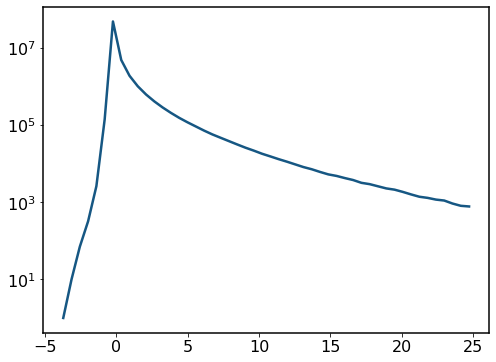

In [87]:
plt.semilogy(TiCO,BiCO)

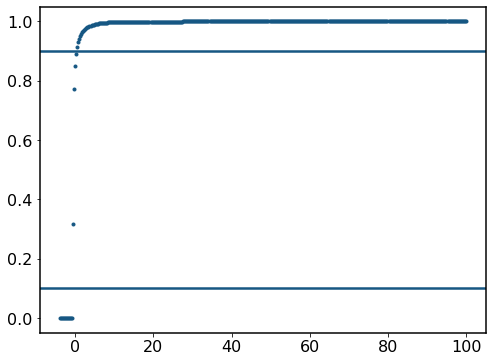

In [72]:
plt.plot(TiCO,np.cumsum(BiCO)/np.sum(BiCO),'.')
plt.axhline(0.1)
plt.axhline(0.9)

### FIRST ATTEMPT, using bins in -1 sigma, 1sigma, 5 sigma (spoiler alert, doesn't work amazingly)

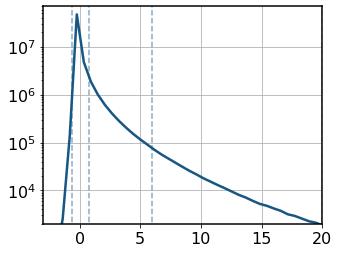

In [66]:
plt.figure(figsize=(5,4))
plt.plot(TiCO, BiCO)
lis = [4,8,16,27]
#for i in range(len(lis)):
#    plt.plot(TiCO[lis[i]]*np.ones((10)), np.logspace(1,8,10), '--C0', alpha=0.5, linewidth=1.5)

plt.plot(-0.6*np.ones((10)), np.logspace(1,8,10), '--C0', alpha=0.5, linewidth=1.5)
plt.plot(0.8*np.ones((10)), np.logspace(1,8,10), '--C0', alpha=0.5, linewidth=1.5)
plt.plot(6*np.ones((10)), np.logspace(1,8,10), '--C0', alpha=0.5, linewidth=1.5)
plt.plot(20*np.ones((10)), np.logspace(1,8,10), '--C0', alpha=0.5, linewidth=1.5)

plt.ylim(2e3,7e7)
plt.xlim(-3, 20)
plt.yscale('log')
plt.grid()

In [82]:
Tvec = np.zeros((len(TiCO),2))
Tvec[:,0] = TiCO
Tvec[:,1] = BiCO
np.save('../../lim_LC_prods/Tvec_BiCO',Tvec)

In [5]:
M_in_survey = np.load('../../lim_LC_prods/M_in_survey.npy')
L_in_survey = np.load('../../lim_LC_prods/L_in_survey.npy')
data = np.load('../../lim_LC_prods/Tvec_BiCO.npy')
TiCO = data[:,0]
BiCO = data[:,1]

In [6]:
M_in_T4=np.load('../../lim_LC_prods/M_in_Tbin4.npy')
L_in_T4=np.load('../../lim_LC_prods/L_in_Tbin4.npy')

M_in_T8=np.load('../../lim_LC_prods/M_in_Tbin8.npy')
L_in_T8=np.load('../../lim_LC_prods/L_in_Tbin8.npy')

M_in_T16=np.load('../../lim_LC_prods/M_in_Tbin16.npy')
L_in_T16=np.load('../../lim_LC_prods/L_in_Tbin16.npy')

M_in_T27=np.load('../../lim_LC_prods/M_in_Tbin27.npy')
L_in_T27=np.load('../../lim_LC_prods/L_in_Tbin27.npy')

In [7]:
len(M_in_T4)

1342

In [28]:
def makemap(cols):
    cmap = clrs.LinearSegmentedColormap.from_list("", cols)
    return cmap

def dispmap(cols):
    f,axes = plt.subplots(figsize=(8,0.5), dpi=100,sharey=True)
    f.subplots_adjust(wspace=0,right=0.99,top=0.99,bottom=0.00,left=0.01,hspace=0.0)
    plt.yticks([])
    arr=np.tile(np.arange(1000),100).reshape(100,1000)
    cmap = makemap(cols)
    plt.imshow(arr,cmap=cmap)

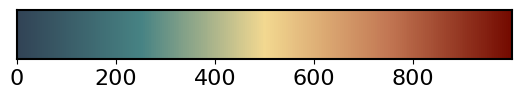

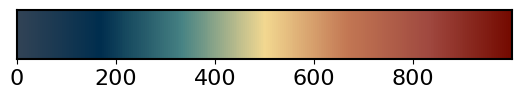

In [29]:
seiheki   = '#478384'
koiai       = '#002E4E'
shuan     = '#740A00'
azuki     = '#A04940'

grey='#324356'
turquoise='#54858a'
#aqua='#5ca191'
yellow='#f0db92'
yellow_orange='#edc080'
orange='#C37854'
gabimap = matplotlib.colors.LinearSegmentedColormap.from_list("", [grey,turquoise,yellow,yellow_orange,orange])

map_br2 = makemap([grey,koiai,seiheki,'#f3d991',orange,azuki,shuan])
map_br = makemap([grey,seiheki,'#f3d991',orange,shuan])

dispmap([grey,seiheki,'#f3d991',orange,shuan])
dispmap([grey,koiai,seiheki,'#f3d991',orange,azuki,shuan])

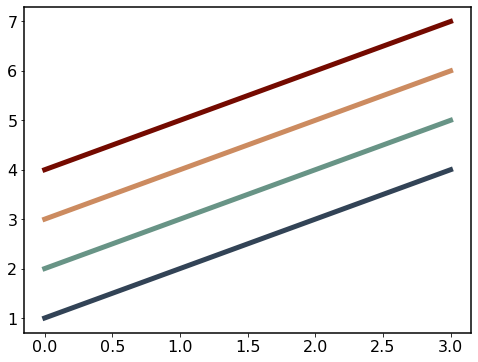

In [47]:
ii = [0,0.3,0.7,0.999]
for i in range(len(ii)):
    plt.plot(np.linspace(1,4,4)+i,c=map_br(ii[i]),lw=5)

In [34]:
Mbin_edges=np.linspace(10.75, 13, 35)
Mbin=(Mbin_edges[1:]+Mbin_edges[:-1])/2
Nbin_tot, _=np.histogram(np.log10(M_in_survey), bins=Mbin_edges, weights=L_in_survey, density=True)

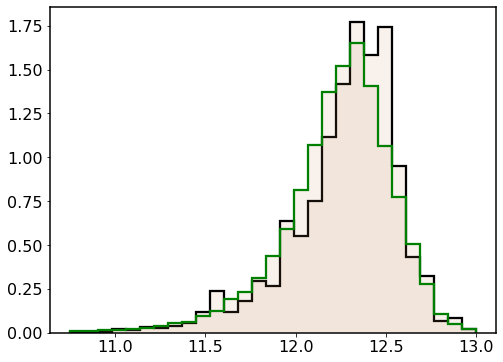

In [14]:
Mbin_edges=np.linspace(10.75, 13, 30)
plt.hist(np.log10(M_in_T27), bins=Mbin_edges, weights=L_in_T27, density=True, 
         color='k', fc=(195/255, 136/255, 84/255, 0.11),
         linewidth=2.25, histtype='step', fill=True, label=r'$\Delta T/\sigma$='+str(np.round(TiCO[8]/1.21, 0)))#+r'$\mu$K')
plt.hist(np.log10(M_in_T8), bins=Mbin_edges, weights=L_in_T8, density=True, 
         color='g', fc=(195/255, 136/255, 84/255, 0.11),
         linewidth=2.25, histtype='step', fill=True, label=r'$\Delta T/\sigma$='+str(np.round(TiCO[8]/1.21, 0)))#+r'$\mu$K')
plt.show()




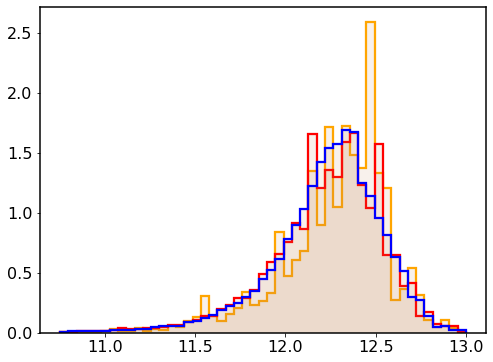

In [9]:
Mbin_edges=np.linspace(10.75, 13, 50)
#plt.hist(np.log10(M_in_T27), bins=Mbin_edges3, weights=L_in_T27, density=True, 
#         color=CLS[0], fc=(195/255, 136/255, 84/255, 0.11),
#         linewidth=2.25, histtype='step', fill=True, label=r'$\Delta T/\sigma$='+str(np.round(TiCO[8]/1.21, 0)))#+r'$\mu$K')
plt.hist(np.log10(M_in_T27), bins=Mbin_edges, weights=L_in_T27, density=True, 
         color='orange', fc=(195/255, 136/255, 84/255, 0.11),
         linewidth=2.25, histtype='step', fill=True, label=r'$\Delta T/\sigma$='+str(np.round(TiCO[8]/1.21, 0)))#+r'$\mu$K')

plt.hist(np.log10(M_in_T16), bins=Mbin_edges, weights=L_in_T16, density=True, 
         color='red', fc=(195/255, 136/255, 84/255, 0.11),
         linewidth=2.25, histtype='step', fill=True, label=r'$\Delta T/\sigma$='+str(np.round(TiCO[8]/1.21, 0)))#+r'$\mu$K')

plt.hist(np.log10(M_in_T8), bins=Mbin_edges, weights=L_in_T8, density=True, 
         color='blue', fc=(195/255, 136/255, 84/255, 0.11),
         linewidth=2.25, histtype='step', fill=True, label=r'$\Delta T/\sigma$='+str(np.round(TiCO[8]/1.21, 0)))#+r'$\mu$K')

plt.show()



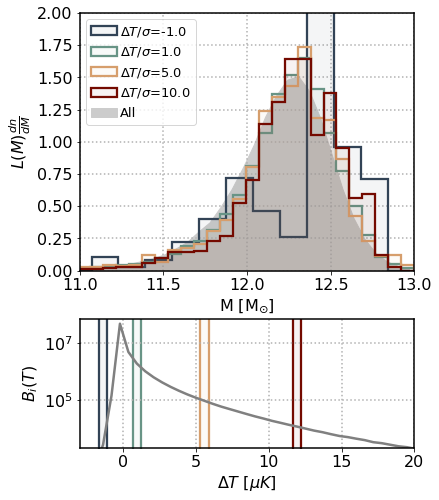

In [48]:
grey='#cccccc'
color1='#d1a862'
color2='#c38854'
color3='#9c4630'
color4='#550022'

CLS = [map_br(0),map_br(0.3),map_br(0.65),map_br(0.999)]
cls = []
for i in range(len(CLS)):
    cls.append(list(CLS[i]))
    cls[i][-1] = 0.05
    cls[i] = tuple(cls[i])

TiCO_edge=np.linspace(-4, 25, 50+1)

Mbin_edges2=np.linspace(10.75, 13, 30)
Mbin_edges3=np.linspace(10.75, 13, 15)


#Nbin_tot, _=np.histogram(np.log10(M_in_survey), bins=Mbin_edges, weights=L_in_survey, density=True)

fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1], 'hspace':0.25}, figsize=(6,8))


ax[0].hist(np.log10(M_in_T4), bins=Mbin_edges3, weights=L_in_T4, density=True, 
         color=CLS[0], fc=cls[0],
         linewidth=2.25, histtype='step', fill=True, label=r'$\Delta T/\sigma$='+str(np.round(TiCO[4]/1.21, 0)))#+r'$\mu$K')

ax[0].hist(np.log10(M_in_T8), bins=Mbin_edges2, weights=L_in_T8, density=True, 
         color=CLS[1], fc=cls[1],
         linewidth=2.25, histtype='step', fill=True, label=r'$\Delta T/\sigma$='+str(np.round(TiCO[8]/1.21, 0)))#+r'$\mu$K')

ax[0].hist(np.log10(M_in_T16), bins=Mbin_edges2, weights=L_in_T16, density=True, 
         color=CLS[2], fc=cls[2],
         linewidth=2.25, histtype='step', fill=True, label=r'$\Delta T/\sigma$='+str(np.round(TiCO[16]/1.21, 0)))#+r'$\mu$K')

ax[0].hist(np.log10(M_in_T27), bins=Mbin_edges2, weights=L_in_T27, density=True, 
         color=CLS[3], fc=cls[3],
         linewidth=2.25,histtype='step', fill=True, label=r'$\Delta T/\sigma$='+str(np.round(TiCO[27]/1.21, 0)))#+r'$\mu$K')
ax[0].fill_between(Mbin, y1=np.zeros((len(Mbin))), y2=Nbin_tot, color=grey, label='All',alpha=1)

ax[0].legend(loc='upper left', handletextpad=0.2, fontsize=13)
ax[0].set_xlabel('M [M$_{\odot}$]')
ax[0].set_ylabel(r'$L(M) \frac{dn}{dM}$')
ax[0].grid(linestyle='dotted', linewidth=1.5)
ax[0].set_ylim(0,2.)
ax[0].set_xlim(11,13)

ax[1].plot(TiCO, BiCO, color='grey')
ax[1].fill_betweenx(np.logspace(1,15,10), x1=TiCO_edge[4]*np.ones((10)), x2=TiCO_edge[5]*np.ones((10)), 
                    color=CLS[0], fc=cls[0], linewidth=2.25)

ax[1].fill_betweenx(np.logspace(1,15,10), x1=TiCO_edge[8]*np.ones((10)), x2=TiCO_edge[9]*np.ones((10)), 
                    color=CLS[1], fc=cls[1], linewidth=2.25)

ax[1].fill_betweenx(np.logspace(1,15,10), x1=TiCO_edge[16]*np.ones((10)), x2=TiCO_edge[17]*np.ones((10)), 
                    color=CLS[2], fc=cls[2], linewidth=2.25)

ax[1].fill_betweenx(np.logspace(1,15,10), x1=TiCO_edge[27]*np.ones((10)), x2=TiCO_edge[28]*np.ones((10)), 
                    color=CLS[3], fc=cls[3], linewidth=2.25)

ax[1].set_ylim(1e3,7e7)
ax[1].set_xlim(-3, 20)
ax[1].set_xlabel(r"$\Delta T$ [$\mu K$]")
ax[1].set_ylabel("$B_{i}(T)$")
ax[1].set_yscale('log')
ax[1].grid(linestyle='dotted', linewidth=1.5)

#plt.savefig('../../VID_properties.png', dpi=300, bbox_inches='tight')
plt.show()

# Getting M and L in all survey

In [22]:
inds_RA = (LC_CO.halo_catalog_all['RA'] > LC_CO.RAObs_min.value)&(LC_CO.halo_catalog_all['RA'] < LC_CO.RAObs_max.value)
inds_DEC = (LC_CO.halo_catalog_all['DEC'] > LC_CO.DECObs_min.value)&(LC_CO.halo_catalog_all['DEC'] < LC_CO.DECObs_max.value)
inds_sky = inds_RA&inds_DEC

cornerside = (LC_CO.raside_lim[1]**2+LC_CO.decside_lim[1]**2)**0.5
ang = np.arctan(cornerside/LC_CO.rside_obs_lim[1])
rbuffer = cornerside/np.sin(ang)
zbuffer = LC_CO.cosmo.redshift_at_comoving_radial_distance((rbuffer*LC_CO.Mpch).value)
nu_min = LC_CO.line_nu0['CO_J10']/(zbuffer+1)

inds = (LC_CO.nuObs_line_halo_all['CO_J10'] >= nu_min)&(LC_CO.nuObs_line_halo_all['CO_J10'] <= LC_CO.nuObs_max)&inds_sky
halos_in_survey = LC_CO.halo_catalog_all[inds]

In [28]:
zmid = (LC_CO.line_nu0[LC_CO.target_line]/LC_CO.nuObs_mean).decompose().value-1
sigma_par_target = (cu.c*LC_CO.dnu*(1+zmid)/(LC_CO.cosmo.hubble_parameter(zmid)*(u.km/u.Mpc/u.s)*LC_CO.nuObs_mean)).to(LC_CO.Mpch).value

Lbox = LC_CO.Lbox.value

Nmesh = np.array([LC_CO.spectral_supersample*np.ceil(Lbox[0]/sigma_par_target),
          LC_CO.angular_supersample*LC_CO.Npixside[0],
          LC_CO.angular_supersample*LC_CO.Npixside[1]], dtype=int)

ramid = 0.5*(LC_CO.RAObs_max + LC_CO.RAObs_min)
decmid = 0.5*(LC_CO.DECObs_max + LC_CO.DECObs_min)

ralim = np.deg2rad(np.array([LC_CO.RAObs_min.value,LC_CO.RAObs_max.value]) - ramid.value) 
declim = np.deg2rad(np.array([LC_CO.DECObs_min.value,LC_CO.DECObs_max.value]) - decmid.value)
raside_lim = LC_CO.raside_lim
decside_lim = LC_CO.decside_lim
rside_obs_lim = LC_CO.rside_obs_lim

mins_obs = np.array([rside_obs_lim[0],raside_lim[0],decside_lim[0]])+0.49999*Lbox/Nmesh

ra,dec,redshift = da.broadcast_arrays(LC_CO.halos_in_survey_all['CO_J10']['RA'], LC_CO.halos_in_survey_all['CO_J10']['DEC'],
                                      LC_CO.halos_in_survey_all['CO_J10']['Zobs'])
r = redshift.map_blocks(lambda zz: (((LC_CO.cosmo.comoving_radial_distance(zz)*u.Mpc).to(LC_CO.Mpch)).value),
                        dtype=redshift.dtype)
ra -= ramid.value
dec -= decmid.value
ra,dec  = da.deg2rad(ra),da.deg2rad(dec)

x = da.cos(dec) * da.cos(ra)
y = da.cos(dec) * da.sin(ra)
z = da.sin(dec)
pos = da.vstack([x,y,z]).T                    
cartesian_halopos = r[:,None] * pos
lategrid = np.array(cartesian_halopos.compute())

filtering = (lategrid[:,0] >= rside_obs_lim[0]) & (lategrid[:,0] <= rside_obs_lim[1]) & \
            (lategrid[:,1] >= raside_lim[0]) & (lategrid[:,1] <= raside_lim[1]) & \
            (lategrid[:,2] >= decside_lim[0]) & (lategrid[:,2] <= decside_lim[1])

M_in_survey = np.asarray((halos_in_survey['M_HALO'][filtering])*(LC_CO.Mpch.to(u.Mpc)))
L_in_survey = np.asarray((LC_CO.halos_in_survey_all['CO_J10']['Lhalo'][filtering]))



In [30]:
M_in_survey=np.save('../../lim_LC_prods/M_in_survey',M_in_survey)
L_in_survey=np.save('../../lim_LC_prods/L_in_survey',L_in_survey)


# second attempt: slices of 1% of all voxels, the dimmest, the mean, the ~2sigma and the brightest

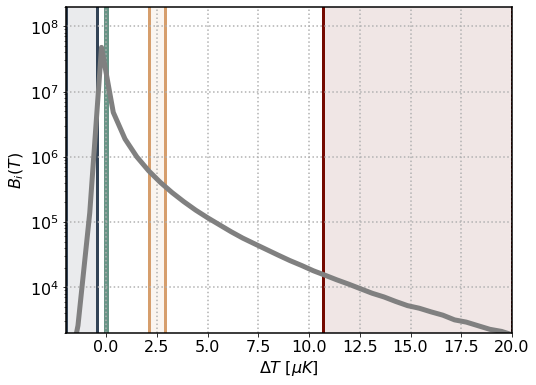

In [247]:
CLS = [map_br(0),map_br(0.3),map_br(0.65),map_br(0.999)]
cls = []
for i in range(len(CLS)):
    cls.append(list(CLS[i]))
    cls[i][-1] = 0.1
    cls[i] = tuple(cls[i])

plt.plot(TiCO, BiCO, color='grey',lw=5)
plt.fill_betweenx(np.logspace(1,15,10), x1=-2*np.ones((10)), x2=-0.4325*np.ones((10)), 
                    color=CLS[0], fc=cls[0], linewidth=3)

plt.fill_betweenx(np.logspace(1,15,10), x1=-0.016, x2=0.016, 
                    color=CLS[1], fc=cls[1], linewidth=4)

plt.fill_betweenx(np.logspace(1,15,10), x1=2.125*np.ones((10)), x2=2.875*np.ones((10)), 
                    color=CLS[2], fc=cls[2], linewidth=3)

plt.fill_betweenx(np.logspace(1,15,10), x1=10.7*np.ones((10)), x2=20, 
                    color=CLS[3], fc=cls[3], linewidth=3)

plt.ylim(2e3,2e8)
plt.xlim(-2, 20)
plt.xlabel(r"$\Delta T$ [$\mu K$]")
plt.ylabel("$B_{i}(T)$")
plt.yscale('log')
plt.grid(linestyle='dotted', linewidth=1.5)

In [213]:
len(np.where(LC_CO.obs_3d_map<=-0.4325)[0])

577620

In [212]:
len(np.where(LC_CO.obs_3d_map<=-0.4325)[0])/aa

0.010028125

In [119]:
aa = LC_CO.obs_3d_map.size

In [211]:
len(np.where(LC_CO.obs_3d_map<=-0.4325)[0])/aa

0.010028125

In [233]:
len(np.where((LC_CO.obs_3d_map>=-0.016)&(LC_CO.obs_3d_map<=0.016))[0])/aa

0.010140972222222221

In [246]:
len(np.where((LC_CO.obs_3d_map>=2.125)&(LC_CO.obs_3d_map<=2.875))[0])/aa

0.010235277777777777

In [187]:
len(np.where((LC_CO.obs_3d_map>=10.7))[0])/aa

0.002008090277777778

In [248]:
np.max(LC_CO.obs_3d_map)

131.61786

In [221]:
3*1.2

3.5999999999999996

In [79]:
NTbin=[2,4,7,22]
CO_map=np.asarray(LC_CO.obs_3d_map)

Xcorner=np.sort(np.asarray(corners[0][:,0,0]))
Xcorner-=np.min(Xcorner)
dXcorner=np.diff(Xcorner)[0]
Ycorner=np.sort(np.asarray(corners[1][0,:,0]))
Ycorner-=np.min(Ycorner)
dYcorner=np.diff(Ycorner)[0]
Zcorner=np.sort(np.asarray(corners[2][0,0,:]))
Zcorner-=np.min(Zcorner)
dZcorner=np.diff(Zcorner)[0]

M_in_Tbin=[]
L_in_Tbin=[]

for n in NTbin:
    print(n)
    Tbin_min=TiCO_edge[n]
    Tbin_max=TiCO_edge[n+1]

    ind_mask=np.asarray(np.where((CO_map>=Tbin_min)&(CO_map<Tbin_max)))

    Xmin=Xcorner[ind_mask[0]]
    Ymin=Ycorner[ind_mask[1]]
    Zmin=Zcorner[ind_mask[2]]

    mask_M=((lategrid[:,0]>=Xmin[0])&(lategrid[:,0]<Xmin[0]+dXcorner)&
            (lategrid[:,1]>=Ymin[0])&(lategrid[:,1]<Ymin[0]+dYcorner)&
            (lategrid[:,2]>=Zmin[0])&(lategrid[:,2]<Zmin[0]+dZcorner))
    for i in range(1,len(Xmin)):
        mask_M=mask_M|((lategrid[:,0]>=Xmin[i])&(lategrid[:,0]<Xmin[i]+dXcorner)&
                       (lategrid[:,1]>=Ymin[i])&(lategrid[:,1]<Ymin[i]+dYcorner)&
                       (lategrid[:,2]>=Zmin[i])&(lategrid[:,2]<Zmin[i]+dZcorner))

    M_in_Tbin.append(np.asarray((halos_in_survey['M_HALO'][filtering])[mask_M]*(LC_CO.Mpch.to(u.Mpc))))
    L_in_Tbin.append(np.asarray((LC_CO.halos_in_survey['CO_J10']['Lhalo'][filtering])[mask_M]))

2
4
7
22
